In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib.pyplot import *
import importlib
import subprocess
import imageio

from ATARI.syndat.particle_pair import Particle_Pair
from ATARI.sammy_interface import sammy_interface, sammy_classes, sammy_functions

import ATARI.utils.io.hdf5 as h5io

from copy import copy
from ATARI.theory.resonance_statistics import make_res_par_avg

from ATARI.theory.scattering_params import FofE_explicit, FofE_recursive

In [2]:
%matplotlib widget

In [3]:
# test = sammy_functions.readpar("/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/JEFF_eval/SAMNDF.PAR")
# test1 = test.iloc[2:, :]
# spin_grouped=test1.groupby('J_ID')


# for each in spin_grouped:
#     par = each[1]
#     print(each[0])

#     # S, P, psi, k = FofE_explicit(par.E.values,  0.81271 , 180.948030, 1, 0)
#     S, P, psi, k = FofE_recursive(par.E.values,  0.81271 , 180.948030, 1, 0)
    
#     print(np.mean(par.Gn1))#/2/P[0,:]))
#     print(np.mean(np.diff(par.E)))

In [4]:
# Functions for setting up feature bank

def get_parameter_grid(energy_grid, res_par_avg, num_Er, option=0):

    # allow Elambda to be just outside of the window
    max_Elam = max(energy_grid) + res_par_avg['Gt99']/10e3
    min_Elam = min(energy_grid) - res_par_avg['Gt99']/10e3

    if option == 1:
        Gn = np.repeat(res_par_avg["Gn01"], num_Er)*1000
        Gg = np.repeat(res_par_avg["<Gg>"], num_Er)
    else:
        Gn = np.repeat(res_par_avg["<Gn>"], num_Er)
        Gg = np.repeat(res_par_avg["<Gg>"], num_Er)
        
    Er = np.linspace(              min_Elam,              max_Elam,                num_Er)
    J_ID = np.repeat(res_par_avg["J_ID"], num_Er)

    return Er, Gg, Gn, J_ID

def get_resonance_ladder(Er, Gg, Gn1, J_ID, varyE=1, varyGg=1, varyGn1=1):
    return pd.DataFrame({"E":Er, "Gg":Gg, "Gn1":Gn1, "varyE":np.ones(len(Er))*varyE, "varyGg":np.ones(len(Er))*varyGg, "varyGn1":np.ones(len(Er))*varyGn1 ,"J_ID":J_ID})

# def get_resonance_ladder_df(resonance_ladder_array):

def plot_trans(exp_pw, T1):
    
    fig = figure()
    # plot(exp_pw.E, exp_pw.theo_trans, ms=1, color='g')
    # plot(sammyOUT.pw.E, sammyOUT.pw.theo_trans, 'r', alpha=0.2, lw=3)
    # plot(sammyOUT_bayes.pw.E, sammyOUT_bayes.pw.theo_trans_bayes, 'b-')
    plot(T1.E, T1.theo_trans, 'b')
    errorbar(exp_pw.E, exp_pw.exp, yerr=exp_pw.exp_unc, zorder=0, 
                                            fmt='.', color='k', linewidth=1, markersize=3, capsize=2, label='exp')
    ylim([-.1, 1])
    return fig


def plot_trans_cap(trans, cap, T1=None,C1=None, plot_true=False):

    fig, axes = subplots(2,1, figsize=(8,6), sharex=True)
    axes[0].errorbar(trans.E, trans.exp, yerr=trans.exp_unc, zorder=0, 
                                            fmt='.', color='k', linewidth=1, markersize=3, capsize=2, label='exp')
    
    axes[1].errorbar(cap.E, cap.exp, yerr=cap.exp_unc, zorder=0, 
                                            fmt='.', color='k', linewidth=1, markersize=3, capsize=2, label='exp')
    
    if C1 is not None and T1 is not None:
        axes[0].plot(T1.E, T1.theo_trans, 'b')
        axes[1].plot(C1.E, C1.theo_xs, 'b')
        if plot_true:
            axes[0].plot(trans.E, trans.true, 'g')
            axes[1].plot(cap.E, cap.true, 'g')
    else:
        axes[0].plot(trans.E, trans.true, 'g')
        axes[1].plot(cap.E, cap.true, 'g')
        

    axes[0].set_ylabel("T")
    # axes[1].set_yscale('log')
    axes[1].set_ylabel(r'$\sigma_{\gamma}$ (barns)')
    # axes[1].set_ylim([-0.1,1.01])

    # legend()
    fig.supxlabel('Energy (eV)')
    fig.tight_layout()
    return fig


def make_gif(sammy_runDIR, pngpath, gifpath, ifinal,trans, cap):

    for i in range(ifinal):
        
        C1 = sammy_functions.readlst(os.path.join(sammy_runDIR,f"results/cap1_step{i}.lst"))
        T1 = sammy_functions.readlst(os.path.join(sammy_runDIR,f"results/trans1_step{i}.lst"))

        fig = plot_trans_cap(trans, cap, T1=T1, C1=C1)
        title(f"step {i}")
        fig.savefig(os.path.join(pngpath, f"{i}.png"))
        close()


    images = []
    for i in range(ifinal): #range(start_job,end_job):
        images.append(imageio.imread(os.path.join(pngpath, f"{i}.png")))
    imageio.mimsave(gifpath, images)


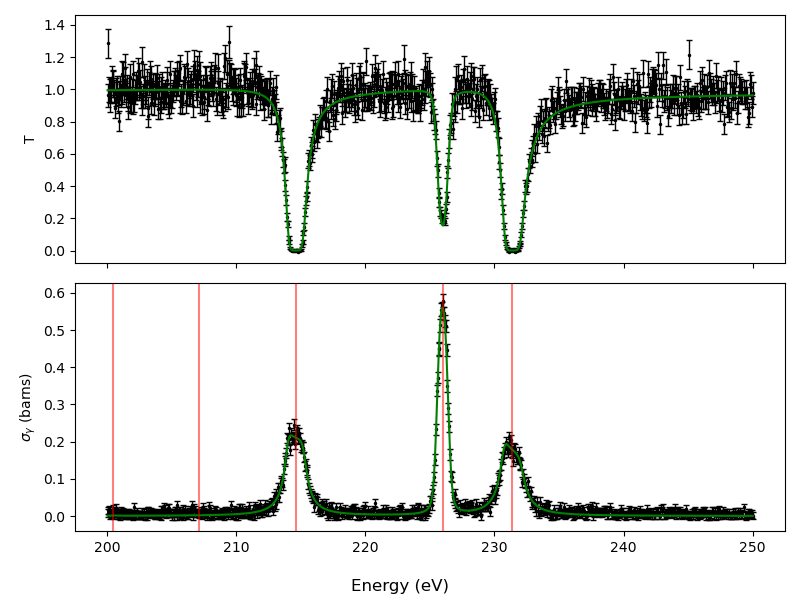

In [5]:
case_file = '/Users/noahwalton/research_local/resonance_fitting/ATARI_workspace/RM_allexp/sammy/data_1.hdf5'  # if using hdf5

isample = 8


dataset_titles = ["trans1", "cap1"]
datasets = []
for dt in dataset_titles:
    exp_pw, exp_cov = h5io.read_pw_exp(case_file, isample, title=dt)
    datasets.append(exp_pw)

theo_par = h5io.read_par(case_file, isample, 'true')  #for fine grid theoretical
theo_par["varyGn1"] = np.ones(len(theo_par))
theo_par["varyGg"] = np.ones(len(theo_par))
theo_par["varyE"] = np.ones(len(theo_par))

trans = datasets[0]
cap = datasets[1]

fig = plot_trans_cap(trans, cap, T1=None, C1=None)

for ir, row in theo_par.iterrows():
    if row.J_ID == 1:
        c = 'red'
    elif row.J_ID ==2:
        c='b'
    axvline(row.E, ymin=0, ymax=1, alpha=0.5, color=c)

In [6]:
spin_groups = [ (3.0,1,0) ,  (4.0,1,0)]
res_par_avg_1 = make_res_par_avg(J_ID=1,
                            D_avg = 8.79, 
                            Gn_avg= 46.4, #0.658, 
                            n_dof = 1, 
                            Gg_avg = 64.0, 
                            g_dof = 1000, 
                            print = False)
res_par_avg_2 = make_res_par_avg(J_ID=2,
                            D_avg = 4.99, 
                            Gn_avg= 35.5, #0.658, 
                            n_dof = 1, 
                            Gg_avg = 64.0, 
                            g_dof = 1000, 
                            print = False)

ac = 0.81271; M = 180.948030; m = 1; I = 3.5; i = 0.5; l_max = 1 
average_parameters = {'3.0':res_par_avg_1, '4.0':res_par_avg_2}

Ta_pair = Particle_Pair( ac, M, m, I, i, l_max,
                                input_options={},
                                spin_groups=spin_groups,
                                average_parameters=average_parameters )   

num_Er = 50
Er_1, Gg_1, Gn_1, J_ID_1 = get_parameter_grid(exp_pw.E, res_par_avg_1, num_Er, option=1)
Er_2, Gg_2, Gn_2, J_ID_2 = get_parameter_grid(exp_pw.E, res_par_avg_2, 0, option=1)

Er = np.concatenate([Er_1, Er_2])
Gg = np.concatenate([Gg_1, Gg_2])
Gn = np.concatenate([Gn_1, Gn_2])
J_ID = np.concatenate([J_ID_1, J_ID_2])
initial_reslad = get_resonance_ladder(Er, Gg, Gn, J_ID, varyE=0, varyGg=0, varyGn1=1)
# # initial_reslad

In [7]:
np.diff(initial_reslad.E.values)
res_par_avg_1["Gn01"]*10

0.07288876607010165

In [16]:
importlib.reload(sammy_functions)
importlib.reload(sammy_classes)

sammyRTO = sammy_classes.SammyRunTimeOptions(
    path_to_SAMMY_exe = '/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy',
    Print = True,
    model = 'XCT'
    )

reactions = ["transmission", "capture"]
# templates = ["allexptot_2sg.inp", "broadcap_2sg.inp"]
templates = ["allexptot_1sg.inp", "allexpcap_1sg.inp"]

sammyINPyw = sammy_classes.SammyInputDataYW(
    particle_pair = Ta_pair,
    resonance_ladder = initial_reslad,  #np.ones(len(theo_par))*1  np.ones(len(theo_par))*64
    # resonance_ladder = pd.concat([initial_reslad, get_resonance_ladder(theo_par["E"].values, theo_par["Gg"].values, theo_par["Gn1"].values*0.1, theo_par["J_ID"].values)]), #theo_par,

    datasets= datasets,
    dataset_titles= dataset_titles,
    reactions= reactions,
    templates= templates,
    
    max_steps = 200,
    iterations = 2,
    step_threshold = 0.1,
    autoelim_threshold = None,

    LS = False,
    LevMar = True,
    LevMarV = 2,
    initial_parameter_uncertainty = .1,

    temp = 304.5,
    FP=75.0,
    frac_res_FP=0.025,
    target_thickness=0.005)



sammyRTO.sammy_runDIR = os.path.realpath("SAMMY_runDIR_test2")
par, lsts = sammy_functions.run_sammy_YW(sammyINPyw, sammyRTO)

Stepping until convergence
chi2 values
step fudge: [trans1 cap1 sum]
0 [1906.57, 369.411, 2275.9809999999998] 0.1
1 [29.6137, 29.1809, 58.7946] 0.2
2 [15.5246, 13.9157, 29.4403] 0.4
3 [15.8976, 13.1183, 29.015900000000002] 0.8
decrease fudge, repeat step 4:
	0.4: [15.9847, 13.1525, 29.1372]
	0.2: [15.9141, 13.0512, 28.9653]
4 0.2: [15.9141, 13.0512, 28.9653]
Chi2 improvement below threshold


12

In [ ]:
# ifinal=7
# make_gif(sammyRTO.sammy_runDIR, "/Users/noahwalton/Documents/GitHub/ATARI/Fitting/noah_dev/fit_w_sammy/figures", 
#          "/Users/noahwalton/Documents/GitHub/ATARI/Fitting/noah_dev/fit_w_sammy/my.gif", ifinal, trans, cap)

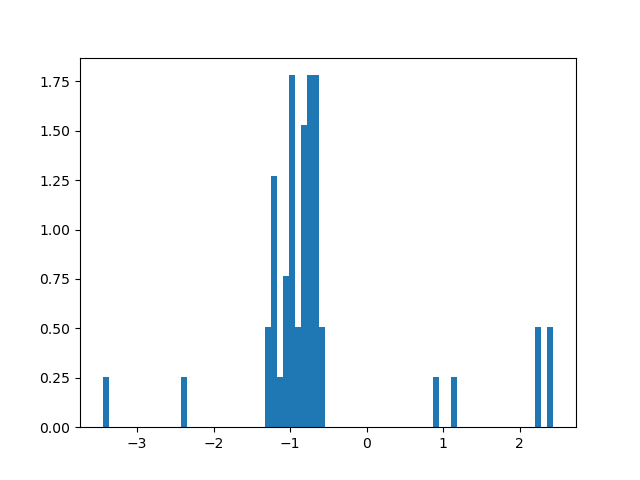

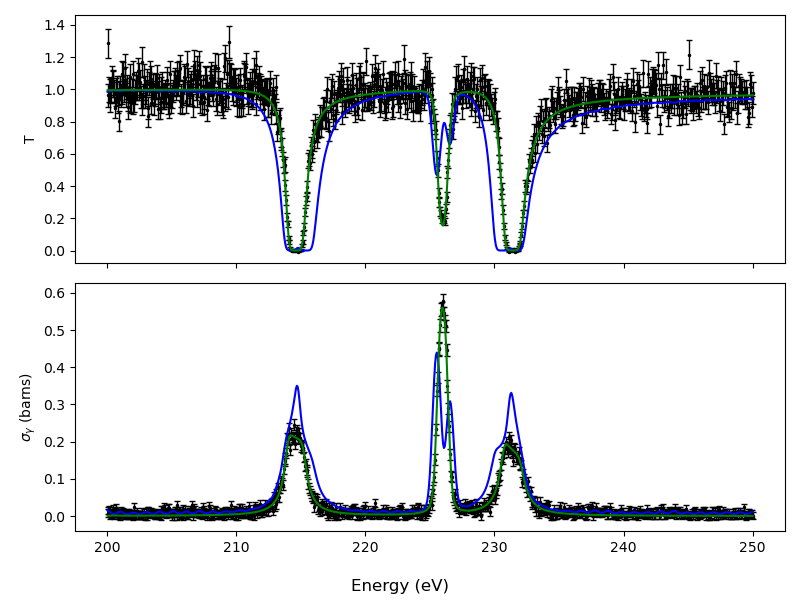

In [17]:
P1 = par
T1, C1 = lsts
# ifinal = 5
# P1 = sammy_functions.readpar(f"/Users/noahwalton/Documents/GitHub/ATARI/Fitting/noah_dev/fit_w_sammy/SAMMY_runDIR_test2/results/step{ifinal}.par")
# T1 = sammy_functions.readlst(f"/Users/noahwalton/Documents/GitHub/ATARI/Fitting/noah_dev/fit_w_sammy/SAMMY_runDIR_test2/iterate/trans1_iter1.lst")
# C1 = sammy_functions.readlst(f"/Users/noahwalton/Documents/GitHub/ATARI/Fitting/noah_dev/fit_w_sammy/SAMMY_runDIR_test2/iterate/cap1_iter1.lst")


figure()

bins = hist(np.log10(P1.Gn1), bins=75, density=True, label="Gn")
# # # bins = hist(np.log10(P1.Gg), bins=75, density=True, alpha=0.75, label="Gg")
# # xlabel(r'Log10($\Gamma$)'); title("Parameter Frequency on Final Step")
# # legend()

# xlim([-8, 3])
# savefig(f"/Users/noahwalton/Documents/GitHub/ATARI/Fitting/noah_dev/fit_w_sammy/case_2a.png")

fig = plot_trans_cap(trans, cap, T1=T1, C1=C1, plot_true=True)
# fig = plot_trans(exp_pw, T1)

In [ ]:
# Pdrive = copy(P1)

# def f(row):
#     if row["Gn1"] > 1:
#         row["varyGn1"] = 0
#     else:
#         pass
#     return row

# sammyRTO.sammy_runDIR= "SAMMY_runDIR_vGnmin"
# sammyINPyw.initial_parameter_uncertainty = 0.01
# sammyINPyw.step_threshold = 0.0001
# sammyINPyw.resonance_ladder = P1 #Pdrive.apply(f, axis=1)
# # par, lsts = run_YW_scheme(sammyINPyw, sammyRTO_ls, P2)
# par, lsts = sammy_functions.run_sammy_YW(sammyINPyw, sammyRTO)

# print(np.count_nonzero(P1.Gn1>1e-2))
# print(np.count_nonzero(par.Gn1>1e-2))

# figure()
# bins = hist(np.log10(par.Gn1), bins=75, density=True, label="P2")
# bins = hist(np.log10(P1.Gn1), bins=75, density=True, label="P1", alpha=0.5)

In [18]:
P2 = copy(P1)

P2 = P2[P2.Gn1 > 1e-1]
P2["varyGg"] = np.ones(len(P2))
P2["varyE"] = np.ones(len(P2))

sammyRTO.sammy_runDIR= os.path.realpath("SAMMY_runDIR_TC_vGn1_E")
sammyINPyw.initial_parameter_uncertainty = 0.1
sammyINPyw.step_threshold = 0.001
sammyINPyw.resonance_ladder = P2
sammyINPyw.LevMarV = 1.1

par, lsts = sammy_functions.run_sammy_YW(sammyINPyw, sammyRTO)

Stepping until convergence
chi2 values
step fudge: [trans1 cap1 sum]
0 [15.8932, 12.9636, 28.8568] 0.1
1 [1.76119, 0.993247, 2.7544370000000002] 0.11000000000000001
2 [1.02609, 0.576411, 1.602501] 0.12100000000000002
3 [1.0218, 0.555139, 1.576939] 0.13310000000000002
4 [1.02118, 0.550965, 1.572145] 0.14641000000000004
5 [1.01982, 0.547784, 1.567604] 0.16105100000000006
6 [1.01811, 0.54369, 1.5618] 0.17715610000000007
7 [1.01653, 0.53985, 1.5563799999999999] 0.1948717100000001
8 [1.01611, 0.539015, 1.555125] 0.2143588810000001
9 0.23579476910000013: [1.01609, 0.538547, 1.554637]
Chi2 improvement below threshold


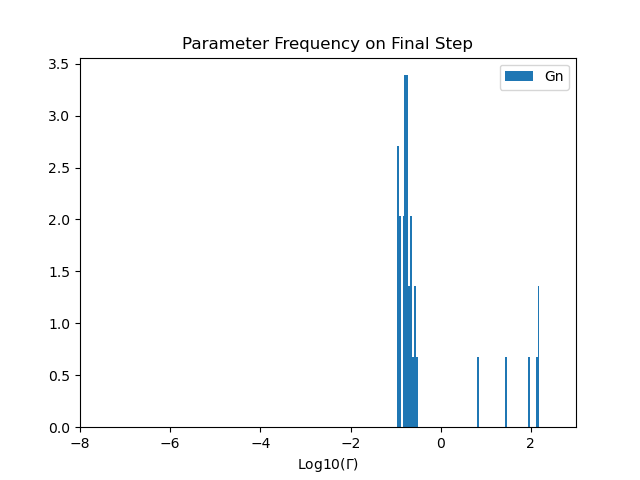

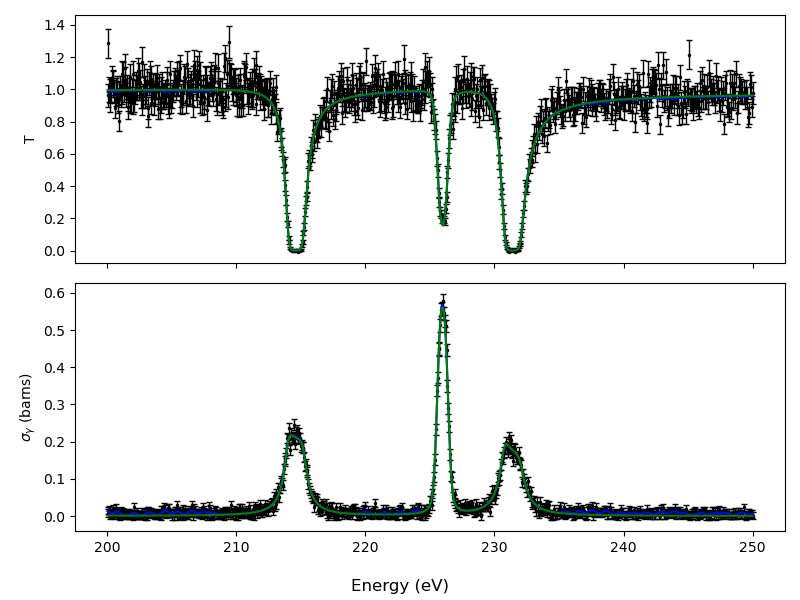

In [19]:
P2 = par
T2, C2 = lsts
# P2 = sammy_functions.readpar(f"/Users/noahwalton/Documents/GitHub/ATARI/Fitting/noah_dev/fit_w_sammy/SAMMY_runDIR_TC_vGn1_E/results/step{ifinal2}.par")
# T2 = sammy_functions.readlst(f"/Users/noahwalton/Documents/GitHub/ATARI/Fitting/noah_dev/fit_w_sammy/SAMMY_runDIR_TC_vGn1_E/iterate/trans1_iter1.lst")
# C2 = sammy_functions.readlst(f"/Users/noahwalton/Documents/GitHub/ATARI/Fitting/noah_dev/fit_w_sammy/SAMMY_runDIR_TC_vGn1_E/iterate/cap1_iter1.lst")

figure()
bins = hist(np.log10(P2.Gn1), bins=75, density=True, label="Gn")
# bins = hist(np.log10(P1.Gg), bins=75, density=True, alpha=0.75, label="Gg")
xlabel(r'Log10($\Gamma$)'); title("Parameter Frequency on Final Step")
legend()
xlim([-8, 3])

fig = plot_trans_cap(trans, cap, T1=T2, C1=C2, plot_true=True)


# for ir, row in P2[P2.Gn1 > 1].iterrows():
#     if row.J_ID == 1:
#         c = 'red'
#     elif row.J_ID ==2:
#         c='b'
#     if row.Gn1 > 1e-1:
#         axvline(row.E, ymin=0, ymax=1, alpha=0.5, color=c)
#     else:
#         pass

In [80]:
res_par_avg_1["Gn01"]

0.007288876607010165

In [ ]:
# P3 = copy(P2)

# P3 = P3[P3.Gn1 > 1e-5]
# P3["varyGg"] = np.ones(len(P3))
# P3["varyE"] = np.ones(len(P3))

# sammyRTO.sammy_runDIR= "SAMMY_runDIR_TC_vall"
# sammyINPyw.step_threshold = 0.0001
# sammyINPyw.initial_parameter_uncertainty = 1
# sammyINPyw.resonance_ladder = P2
# par, lsts = run_YW_scheme(sammyINPyw, sammyRTO_ls, P2)
# par, lsts = sammy_functions.run_sammy_YW(sammyINPyw, sammyRTO)

In [ ]:
# P3 = par
# T3, C3 = lsts


# figure()
# bins = hist(np.log10(P3.Gn1), bins=75, density=True, label="Gn")
# # bins = hist(np.log10(P1.Gg), bins=75, density=True, alpha=0.75, label="Gg")
# xlabel(r'Log10($\Gamma$)'); title("Parameter Frequency on Final Step")
# legend()
# xlim([-8, 3])

# fig = plot_trans_cap(trans, cap, T1=T3, C1=C3,plot_true=True)



# for ir, row in par.iterrows():
#     if row.J_ID == 1:
#         c = 'red'
#     elif row.J_ID ==2:
#         c='b'
#     if row.Gn1 > 1e-1:
#         axvline(row.E, ymin=0, ymax=1, alpha=0.5, color=c)
#     else:
#         pass

In [ ]:
# par[par.Gn1 > 1e-1]

In [ ]:
# # ifinal2 = 200
# ifinal3 = int(result3.splitlines()[-1]) - 1

# P4 = sammy_functions.readpar(os.path.join(sammyRTO_ls.sammy_runDIR,f"results/step{ifinal3}.par"))
# T4 = sammy_functions.readlst(os.path.join(sammyRTO_ls.sammy_runDIR,f"results/trans1_step{ifinal3}.lst"))

# C4 = sammy_functions.readlst(os.path.join(sammyRTO_ls.sammy_runDIR,f"results/cap1_step{ifinal3}.lst"))

# fig = plot_trans_cap(exp_pw, cap_pw, T1=T4, C1=C4, plot_true=True)

In [ ]:
# import imageio

# for i in range(1,ifinal):
    
#     # C1 = sammy_functions.readlst(os.path.join(sammyRTO.sammy_runDIR,f"results/cap1_step{i}.lst"))
#     T1 = sammy_functions.readlst(os.path.join(sammyRTO.sammy_runDIR,f"results/trans1_step{i}.lst"))

#     # fig = plot_trans_cap(exp_pw, cap_pw, T1=T1, C1=C1)
#     fig = plot_trans(exp_pw, T1)
#     fig.savefig(f"/Users/noahwalton/Documents/GitHub/ATARI/Fitting/noah_dev/fit_w_sammy/figures/case2a_{i}.png")
#     close()


# images = []
# for i in range(1,ifinal): #range(start_job,end_job):
#     images.append(imageio.imread(f"/Users/noahwalton/Documents/GitHub/ATARI/Fitting/noah_dev/fit_w_sammy/figures/case2a_{i}.png"))
# imageio.mimsave(f"/Users/noahwalton/Documents/GitHub/ATARI/Fitting/noah_dev/fit_w_sammy/case_2a.gif", images)


In [ ]:
# os.system(os.path.join(sammyRTO.sammy_runDIR, 'run.zsh'))
